# Weibull and Gumbel statistics for Rigid Lay

In [3]:
import nbpresent
nbpresent.__version__

'3.0.2'

In [4]:
import time
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
from peak_finder import fetch_timetrace, global_peaks, weibull_fit, weib2gumb
%matplotlib inline
plt.rcParams['figure.figsize'] =(16.0, 6.0)

In [5]:
# autoreload modules after changes
%load_ext autoreload
%autoreload 2

In [17]:
# %% Load data
pth = r'I:\Stavanger\02 STVR BU ManCom and Dept\05 - Engineering\051 Analysis\Developments\RigidMethod\rayl_weib_gumb\01_sens\runs\Hs3.60_Tp08.00_WD75_seed1timetraces.txt'
ttraces = fetch_timetrace(pth)

# %% Also load the 30 seeds runs for the multi-seed Gumbel method
df = pd.read_table(r'I:\Stavanger\02 STVR BU ManCom and Dept\05 - Engineering\051 Analysis\Developments\RigidMethod\rayl_weib_gumb\01_sens\Results.txt')

Loading I:\Stavanger\02 STVR BU ManCom and Dept\05 - Engineering\051 Analysis\Developments\RigidMethod\rayl_weib_gumb\01_sens\runs\Hs3.60_Tp08.00_WD75_seed1timetraces.txt.Done.


In [18]:
def process(signal, times, extreme_peaks_gumbel):
    
    # %% Detect peaks
    sample, spl_times = global_peaks(signal, times)
    sorted_sample = sorted(sample)

    # %% Fit a Weibull distrubution to the peaks
    # shape, loc, scale
    wb_params_pwm = weibull_fit(sorted_sample)
    wb = ss.frechet_r(*wb_params_pwm)

    # Also calculate the Rayleigh MPM
    MPM_Rayleigh = sum(sample)/len(sample) + np.array(sample).std() * (2*np.log(len(sample)))**0.5

    # %% Calculate a Gumbel distribution for the extreme response
    gb_params = weib2gumb(wb_params_pwm, len(sample))
    gd = ss.gumbel_r(*gb_params)

    # Fit a Gumbel distribution to the peaks from 30 seeds
    params_gb30 = ss.gumbel_r.fit(extreme_peaks_gumbel)
    gb30 = ss.gumbel_r(*params_gb30)


    # %% Print statistics of peaks of 1 simulations
    print('Weibull method - 1 simulation')
    print('*'*30)
    print('Signal mean', sum(signal)/len(signal))
    print('Peaks', len(sample))
    print('Min', min(sample))
    print('Mean', sum(sample)/len(sample))
    print('Max', max(sample))
    print('Std', np.array(sample).std())
    print('P10', np.percentile(sample, 10))
    print('P50', np.percentile(sample, 50))
    print('P90', np.percentile(sample, 90))
    print('P99', np.percentile(sample, 99))
    print('MPM Gumbel', gd.ppf(0.37))
    print('MPM 1/N', wb.ppf(1-1/len(sample)))
    print('MPM Rayleigh', MPM_Rayleigh)
    print('Weibull parameters', wb_params_pwm)
    print('Gumbel parameters', gb_params)
    print('Weibull Percentile of Gumbel P37', 100*wb.cdf(gd.ppf(0.37)))
    print()
    print('Gumbel method - 30 simulations')
    print('*'*30)
    print('Min', min(extreme_peaks_gumbel))
    print('Mean', sum(extreme_peaks_gumbel)/len(extreme_peaks_gumbel))
    print('Max', max(extreme_peaks_gumbel))
    print('Std', np.array(extreme_peaks_gumbel).std())
    print('P10', np.percentile(extreme_peaks_gumbel, 10))
    print('P50', np.percentile(extreme_peaks_gumbel, 50))
    print('P90', np.percentile(extreme_peaks_gumbel, 90))
    print('Gumbel P90', gb30.ppf(0.9))
    print('MPM', gb30.ppf(0.37))

    print('Parameters', params_gb30)

    # Quality plots
    # #############

    # %% Gumbel extreme
    xg = np.linspace(gd.ppf(0.0001), gd.ppf(0.999),100)
    yg = gd.pdf(xg)

    plt.subplot(221)
    plt.plot(sorted_sample, wb.pdf(sorted_sample), label='Weibull of peaks')
    plt.plot(xg, yg, label='Gumbel from Weibull')
    plt.plot(xg, gb30.pdf(xg), label='Gumbel from 30 seeds')
    plt.hist(sample, bins=20, normed=True, alpha=0.5)
    plt.plot([wb.ppf(1-1/len(sample))]*2, [0, 0.045], label='Weibull MPM 1/N')
    plt.plot([MPM_Rayleigh]*2, [0, 0.045], label='Rayleigh MPM')
    plt.title('Peaks, Weibull and Extreme Gumbel')
    plt.legend(loc='best')
    plt.grid()
    #plt.show()
    #plt.close()

    # %% Log-Log paperof Weibull
    x = np.linspace(sorted_sample[0], sorted_sample[-1])
    N = len(sample)
    y = np.array([(i+1)/(N+1) for i in range(N)])
    loc = wb_params_pwm[1]
    plt.subplot(222)
    plt.plot(np.log(sorted_sample-loc), np.log(np.log(1/(1-y))), '+')
    plt.plot(np.log(x-loc), np.log(np.log(1/(1-wb.cdf(x)))))
    plt.title('Weibull of Peaks - loglog x log scale')
    plt.grid()
    #plt.show()
    #plt.close()

    # %% Gumbel extremes
    N = 30
    extremes = sorted_sample[-N:]
    # %% Timetrace, peaks, and extreme peaks
    plt.subplot(223)
    plt.plot(times, signal)
    plt.plot(spl_times, sample, 'o')
    signal_list = list(signal)
    time_extremes = [times[signal_list.index(x)] for x in extremes]
    plt.plot(time_extremes,extremes, 'sr')
    plt.grid()
    plt.title('Timetraces, peaks and extreme peaks')
    plt.xlabel('Time')
    plt.ylabel('Variate')
    #plt.show()
    #plt.close()

    # Gumbel paper 
    x = np.linspace(extremes[0], extremes[-1])
    # Not sure which empirical distribution to use ... here's 2 options:
    y = np.array([(i-0.4+1)/(N+0.4) for i in range(N)])
    # y = np.linspace(gd.cdf(extremes[0]), gd.cdf(extremes[-1]), N)
    y30 = np.array([(i-0.4+1)/(30+0.4) for i in range(30)])
    plt.subplot(224)
    plt.plot(extremes, -np.log(-np.log(y)), '+', label='pks 1 sim')
    plt.plot(x, -np.log(-gd.logcdf(x)), label='Wb->Gb')
    plt.plot(sorted(extreme_peaks_gumbel), -np.log(-np.log(y30)), 'x', label='30 sims')
    plt.plot(x, -np.log(-gb30.logcdf(x)), label='Gb 30')
    plt.plot((extremes[0], extremes[-1]), -np.log(-np.log([0.37, 0.37])))
    plt.grid(); plt.title('Gumble of extreme peaks'); plt.legend(loc='best'); 
    plt.show()
    #plt.close()

In [19]:
# Check what we've got
print('Time Traces')
for key in ttraces:
    print('  ', key)
print('Results')
for cl in df.columns:
    print('  ', cl)

Time Traces
   Pipe DNV OS F101 Load Controlled EndA
   Pipe Bend Moment enda
   Pipe Effective Tension touchdown
   Time
   Pipe Bend Moment touchdown
   Pipe Effective Tension enda
Results
   WaveHs
   WaveTp
   WaveDirection
   Pipe Max Effective Tension EndA
   Pipe Min Effective Tension EndA
   Pipe Max Bend Moment EndA
   Pipe Max Effective Tension TDP
   Pipe Min Effective Tension TDP
   Pipe Max Bend Moment TDP
   Pipe Max DNV OS F101 Load Controlled EndA


In [20]:
list_vars = [
              ('Pipe DNV OS F101 Load Controlled EndA', 'Pipe Max DNV OS F101 Load Controlled EndA'), 
              ('Pipe Effective Tension enda', 'Pipe Max Effective Tension EndA'),
              ('Pipe Bend Moment touchdown', 'Pipe Max Bend Moment TDP'),
            ]
def run(tt, evs):
    print('\n\n', '*' * 80, '\n', tt, '\n', '*' * 80, '\n')
    
    # Time trace for Weibull method
    times = ttraces['Time']
    signal = ttraces[tt]

    # And extreme peaks from 30 seeds
    extreme_peaks_gumbel = df[evs]
    
    process(signal, times, extreme_peaks_gumbel)



 ******************************************************************************** 
 Pipe DNV OS F101 Load Controlled EndA 
 ******************************************************************************** 

Weibull method - 1 simulation
******************************
Signal mean 0.0641225132267
Peaks 1225
Min 0.064148
Mean 0.169215711837
Max 1.085434
Std 0.124972725142
P10 0.0730964
P50 0.125739
P90 0.3140818
P99 0.6619716
MPM Gumbel 1.0344320964
MPM 1/N 1.03348985641
MPM Rayleigh 0.640503620455
Weibull parameters (0.83086346488905682, 0.067759008836406065, 0.091100893016201542)
Gumbel parameters (1.0334898564146144, 0.16346106425822426)
Weibull Percentile of Gumbel P37 99.9188365105

Gumbel method - 30 simulations
******************************
Min 0.647191
Mean 0.887405966667
Max 1.136797
Std 0.114266973741
P10 0.7546766
P50 0.8899235
P90 1.0112869
Gumbel P90 1.08803554958
MPM 0.830001899375
Parameters (0.82933924966514605, 0.11495736574971795)


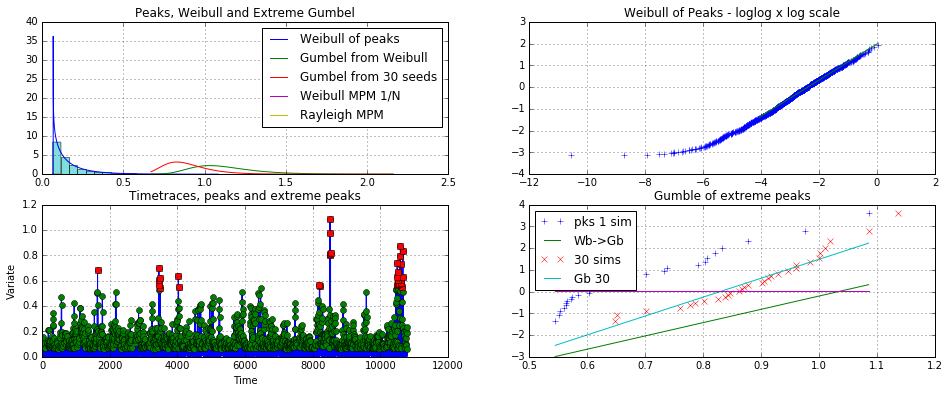

In [21]:
run(*list_vars[0])



 ******************************************************************************** 
 Pipe Effective Tension enda 
 ******************************************************************************** 

Weibull method - 1 simulation
******************************
Signal mean 52.1257990046
Peaks 1445
Min 52.311119
Mean 162.234183363
Max 602.164612
Std 66.689578404
P10 86.728461
P50 151.150192
P90 246.3811124
P99 354.56318968
MPM Gumbel 434.728004584
MPM 1/N 434.555037578
MPM Rayleigh 416.633109651
Weibull parameters (1.7516823406655511, 52.121456532652317, 123.17527452612146)
Gumbel parameters (434.55503757757782, 30.00654962779528)
Weibull Percentile of Gumbel P37 99.9311936817

Gumbel method - 30 simulations
******************************
Min 433.984436
Mean 523.650978633
Max 605.131592
Std 51.3223853736
P10 455.513422
P50 522.17218
P90 589.189978
Gumbel P90 604.064823181
MPM 498.326377536
Parameters (498.05483329990909, 47.107860389894938)


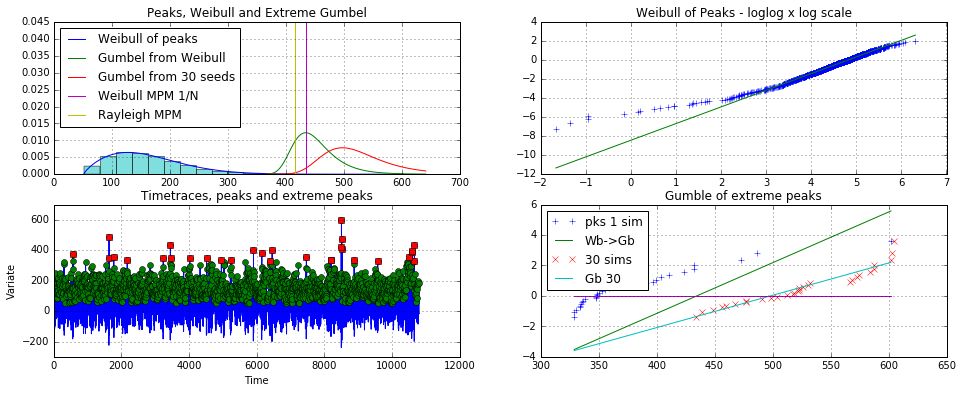

In [22]:
run(*list_vars[1])



 ******************************************************************************** 
 Pipe Bend Moment touchdown 
 ******************************************************************************** 

Weibull method - 1 simulation
******************************
Signal mean 61.7332070231
Peaks 1199
Min 61.759917
Mean 109.609774179
Max 251.986449
Std 32.8926727121
P10 71.739942
P50 103.666408
P90 153.791299
P99 206.54704412
MPM Gumbel 247.849698145
MPM 1/N 247.756182343
MPM Rayleigh 233.464932231
Weibull parameters (1.6575338218490314, 57.122311979143511, 58.482793609086265)
Gumbel parameters (247.75618234311585, 16.223247501375138)
Weibull Percentile of Gumbel P37 99.9170766181

Gumbel method - 30 simulations
******************************
Min 221.504206
Mean 242.3443577
Max 264.221226
Std 10.5107057706
P10 227.5004927
P50 243.330421
P90 253.5439333
Gumbel P90 260.365301988
MPM 237.028863059
Parameters (236.96893333917336, 10.396688738432346)


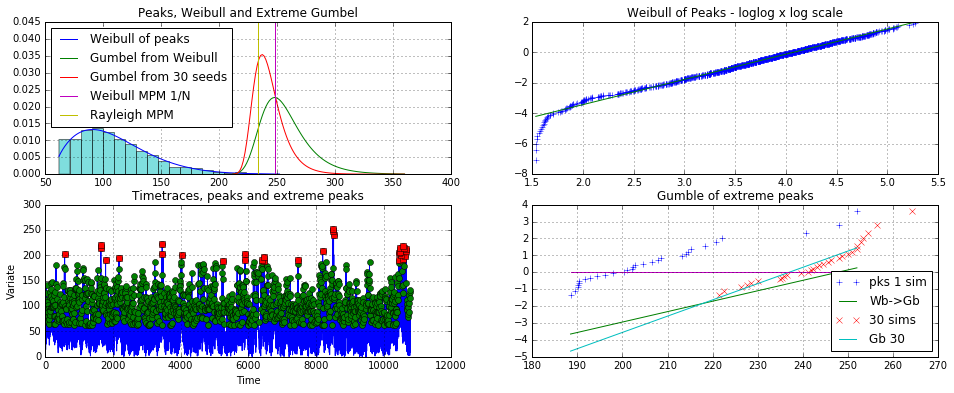

In [23]:
run(*list_vars[2])

In [43]:
print(time.asctime())

Wed Nov 14 07:38:49 2018
